<div class="alert alert-block alert-success">
    <h1 align="center">Plant Classification</h1>
    <h3 align="center">A2NDL POLIMI</h3>

</div>

*italicised text*# **Transfer_Learning**

### Giving Weight

In [ ]:
batch_size = 32
learning_rate = 0.01
epochs = 40

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Assuming you have calculated class weights using compute_class_weight
class_weights = compute_class_weight('balanced', classes=[0, 1], y=cleaned_y)

class_weights_dict = {0: class_weights[0], 1: class_weights[1]}
class_weights_dict

{0: 0.8068365043534343, 1: 1.3147661586967945}

### Data_augumentation

In [ ]:
data_augmentation  = tf.keras.Sequential([
        tfkl.RandomBrightness(0.2, value_range=(0,1)),
        tfkl.RandomTranslation(0.2,0.2),

    ], name='preprocessing')

### 20-Transfer Learning

In [ ]:
def define_model(model_name, input_shape, fine_tune_at, base_learning_rate=0.0001):
  My_all_callbacks = [earlystopping(),Checkpoint(address=f'/content/checkpoint/{model_name}')]

  global x_train,y_train, x_val,y_val, x_test, y_test, class_weights_dict

  x_train_1 =x_train.copy()
  x_val_1 = x_val.copy()
  x_test_1 = x_test.copy()

  dictionary = {}
  test_accuracy ={}

  dictionary_fine ={}
  test_accuracy_fine = {}

  if model_name == "ResNet50":
    preprocess_input = tf.keras.applications.resnet.preprocess_input
  elif model_name == "VGG16" :
    preprocess_input = tf.keras.applications.vgg16.preprocess_input
  elif model_name == "MobileNet" :
    preprocess_input = tf.keras.applications.mobilenet.preprocess_input
  elif model_name == "EfficientNetB2" :
    preprocess_input = tf.keras.applications.efficientnet.preprocess_input
  elif model_name == "EfficientNetV2M" :
    preprocess_input = tf.keras.applications.efficientnet_v2.preprocess_input
  elif model_name == "Xception":
    preprocess_input = tf.keras.applications.xception.preprocess_input
  elif model_name == "ResNet152V2":
    preprocess_input = tf.keras.applications.resnet_v2.preprocess_input

  # Prepocess
  x_train1 = preprocess_input(x_train_1)
  x_val1 = preprocess_input(x_val_1)
  x_test1 = preprocess_input(x_test_1)

  base_model = getattr(tf.keras.applications, model_name)

  base_model = base_model(input_shape=input_shape,
                                               include_top=False,
                                               weights='imagenet')

  base_model.trainable = False # Make all layers freeze
  summary = base_model.summary()
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
  prediction_layer = tf.keras.layers.Dense(1)

  # Create_model
  inputs = tf.keras.Input(shape=input_shape)
  x = data_augmentation(inputs) # data augumentation
  x = base_model(x, training=False)
  x = global_average_layer(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  outputs = prediction_layer(x)
  model = tf.keras.Model(inputs, outputs)

  # Compile model
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')])

  # Fit Model
  history = model.fit(x = x_train1,
    y = y_train,
    validation_data = (x_val1, y_val),
    batch_size = batch_size,
    epochs = epochs,
    callbacks=My_all_callbacks).history

  # add result to dictionary
  dictionary[f'{model_name}'] = history

  # Plot
  plot_accuracy(history = history, title=f'{model_name}')

  # Evaluate
  test_acc = model.evaluate(x_test1,y_test)
  test_accuracy[f'{model_name}'] = test_acc

  print("*"*100)
  print("Fine_tuning is doing")
  ##################################################################################################################################################
  # Fine_tuning
  fine_tune_at = fine_tune_at

  # Unfreez all
  base_model.trainable = True
  # Freeze all the layers before the `fine_tune_at` layer
  for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

  # Compile
  model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/100),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')])

  # Fit
  history1 = model.fit(x = x_train1,
    y = y_train,
    validation_data = (x_val1, y_val),
    batch_size = batch_size,
    epochs = epochs,
    callbacks=My_all_callbacks).history

  # add result to dictionary
  dictionary_fine[f'{model_name}_fine_tuned'] = history1


  # plot
  plot_accuracy(history = history1, title=f'{model_name}_fine_tuned')

  #Evaluate

  # Evaluate
  test_acc_fine = model.evaluate(x_test1,y_test)
  test_accuracy_fine[f'{model_name}_fine_tuned'] = test_acc_fine

  print(f"{model_name} process finished here")
  print('*'*100)
  return   dictionary, dictionary_fine, test_accuracy, test_accuracy_fine

In [ ]:
model_names = ["MobileNet", "VGG16","ResNet50","EfficientNetB2","EfficientNetV2M","Xception","ResNet152V2"]

17225924/17225924 [==============================] - 0s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv1 (Conv2D)              (None, 48, 48, 32)        864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 48, 48, 32)        128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 48, 48, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 48, 48, 32)        288       
 )                                                               
                                                 

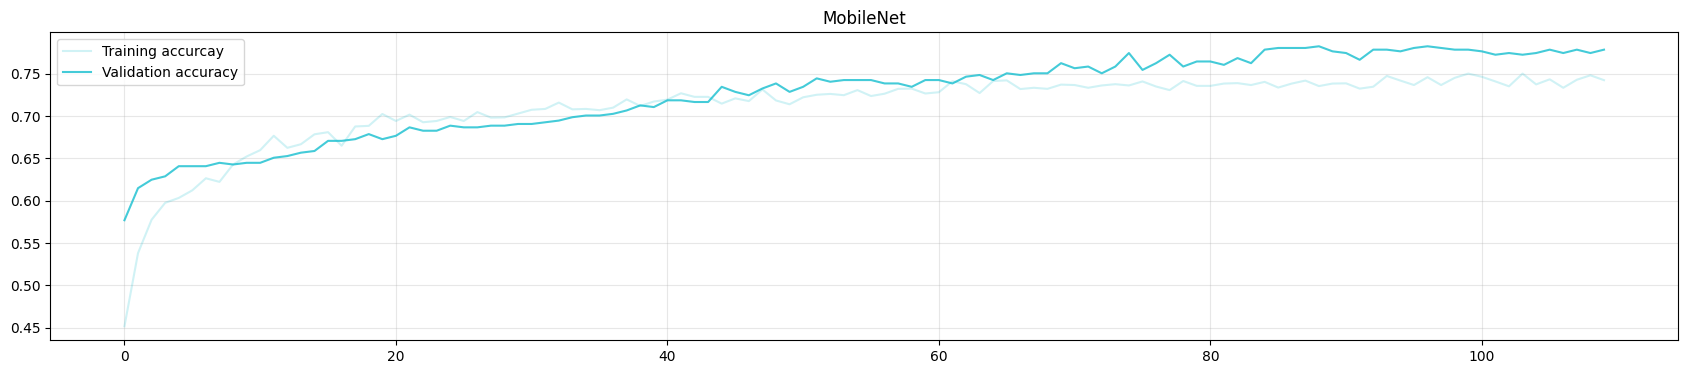

16/16 [==============================] - 1s 25ms/step - loss: 0.5921 - accuracy: 0.7305
****************************************************************************************************
Fine_tuning is doing
Epoch 1/150
61/63 [============================>.] - ETA: 0s - loss: 0.5277 - accuracy: 0.7369
Epoch 1: val_accuracy did not improve from 0.78244
63/63 [==============================] - 5s 37ms/step - loss: 0.5264 - accuracy: 0.7384 - val_loss: 0.5172 - val_accuracy: 0.7745
Epoch 2/150
61/63 [============================>.] - ETA: 0s - loss: 0.5340 - accuracy: 0.7334
Epoch 2: val_accuracy did not improve from 0.78244
63/63 [==============================] - 1s 23ms/step - loss: 0.5329 - accuracy: 0.7326 - val_loss: 0.5175 - val_accuracy: 0.7745
Epoch 3/150
61/63 [============================>.] - ETA: 0s - loss: 0.5284 - accuracy: 0.7444
Epoch 3: val_accuracy did not improve from 0.78244
63/63 [==============================] - 1s 22ms/step - loss: 0.5289 - accuracy: 0.7431 - va

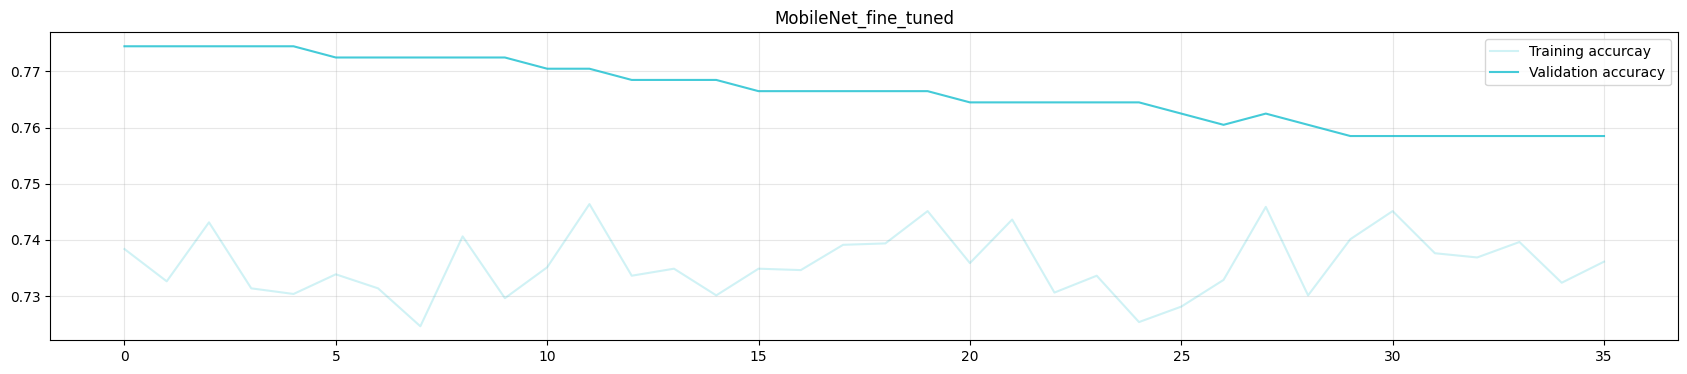

16/16 [==============================] - 0s 14ms/step - loss: 0.5920 - accuracy: 0.7305
MobileNet process finished here
****************************************************************************************************
58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48,

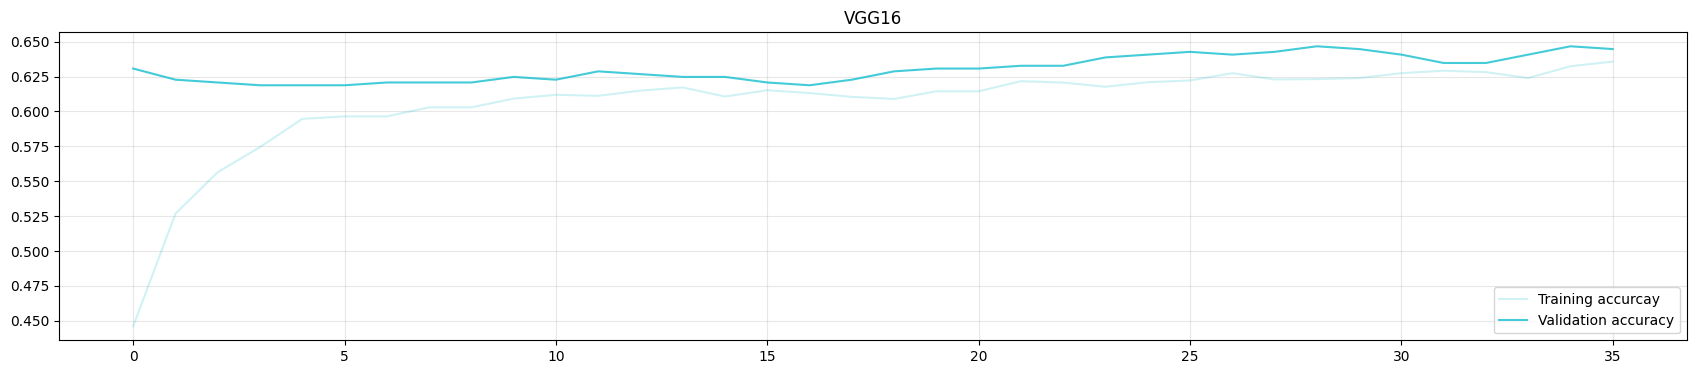

16/16 [==============================] - 2s 83ms/step - loss: 2.6904 - accuracy: 0.6267
****************************************************************************************************
Fine_tuning is doing
Epoch 1/150
62/63 [============================>.] - ETA: 0s - loss: 0.7206 - accuracy: 0.4808
Epoch 1: val_accuracy did not improve from 0.64671
63/63 [==============================] - 6s 68ms/step - loss: 0.7209 - accuracy: 0.4803 - val_loss: 2.4438 - val_accuracy: 0.6307
Epoch 2/150
62/63 [============================>.] - ETA: 0s - loss: 0.7172 - accuracy: 0.4866
Epoch 2: val_accuracy did not improve from 0.64671
63/63 [==============================] - 4s 60ms/step - loss: 0.7171 - accuracy: 0.4865 - val_loss: 2.4527 - val_accuracy: 0.6327
Epoch 3/150
62/63 [============================>.] - ETA: 0s - loss: 0.7228 - accuracy: 0.4821
Epoch 3: val_accuracy did not improve from 0.64671
63/63 [==============================] - 4s 64ms/step - loss: 0.7235 - accuracy: 0.4800 - va

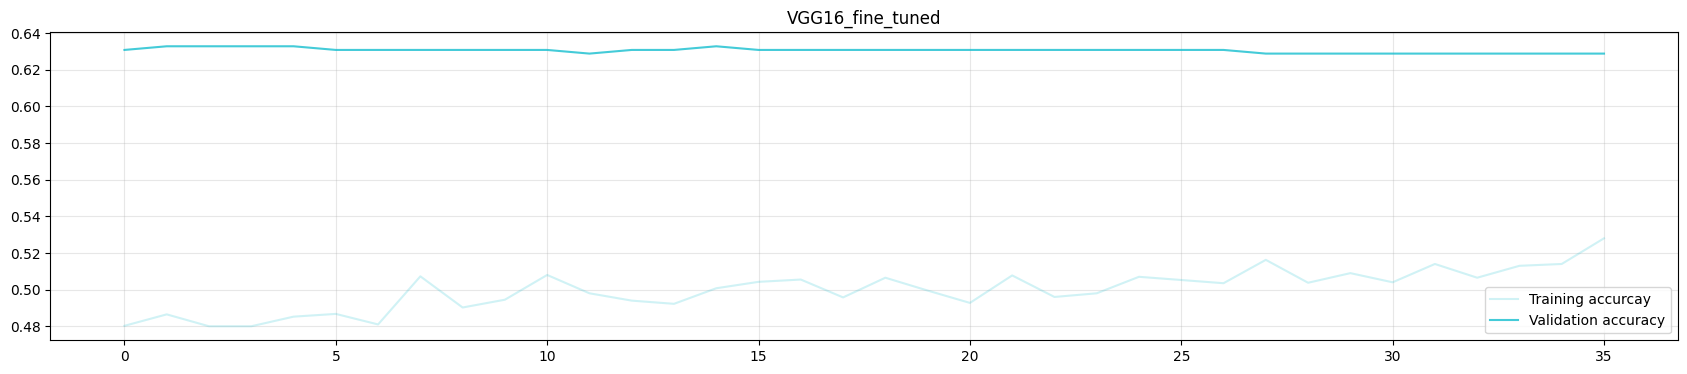

16/16 [==============================] - 1s 32ms/step - loss: 2.7012 - accuracy: 0.6267
VGG16 process finished here
****************************************************************************************************
94765736/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 102, 102, 3)          0         ['input_5[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 48, 48, 64)           9472      ['conv1_pad[0][0]']           
       

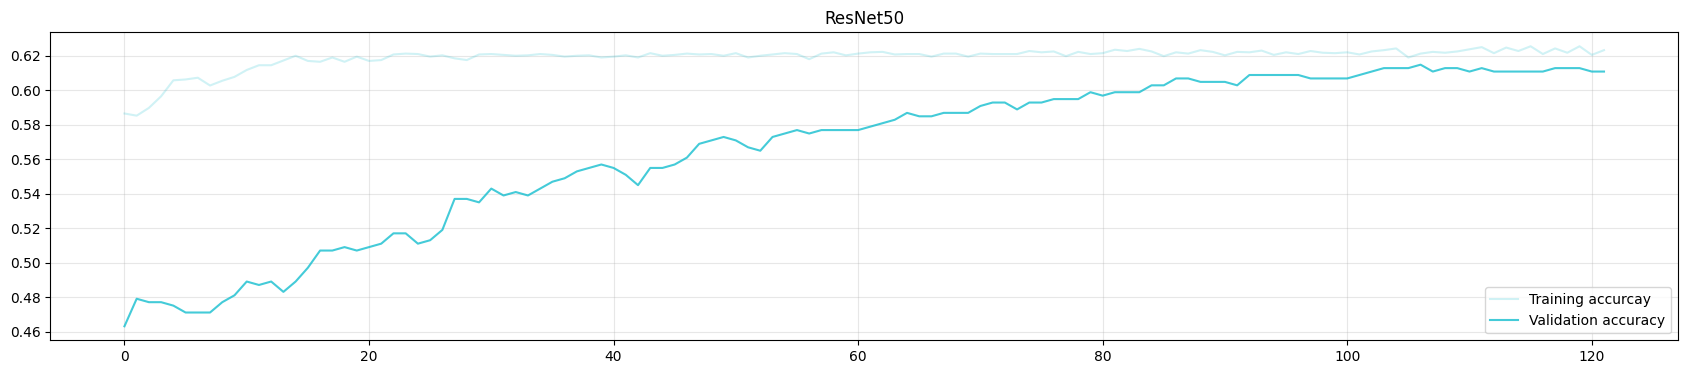

16/16 [==============================] - 2s 61ms/step - loss: 1.0617 - accuracy: 0.6008
****************************************************************************************************
Fine_tuning is doing
Epoch 1/150
63/63 [==============================] - ETA: 0s - loss: 0.6540 - accuracy: 0.6237
Epoch 1: val_accuracy did not improve from 0.61477
63/63 [==============================] - 17s 115ms/step - loss: 0.6540 - accuracy: 0.6237 - val_loss: 1.0999 - val_accuracy: 0.6048
Epoch 2/150
62/63 [============================>.] - ETA: 0s - loss: 0.6562 - accuracy: 0.6220
Epoch 2: val_accuracy did not improve from 0.61477
63/63 [==============================] - 5s 77ms/step - loss: 0.6556 - accuracy: 0.6222 - val_loss: 1.1044 - val_accuracy: 0.6028
Epoch 3/150
63/63 [==============================] - ETA: 0s - loss: 0.6529 - accuracy: 0.6194
Epoch 3: val_accuracy did not improve from 0.61477
63/63 [==============================] - 5s 81ms/step - loss: 0.6529 - accuracy: 0.6194 - 

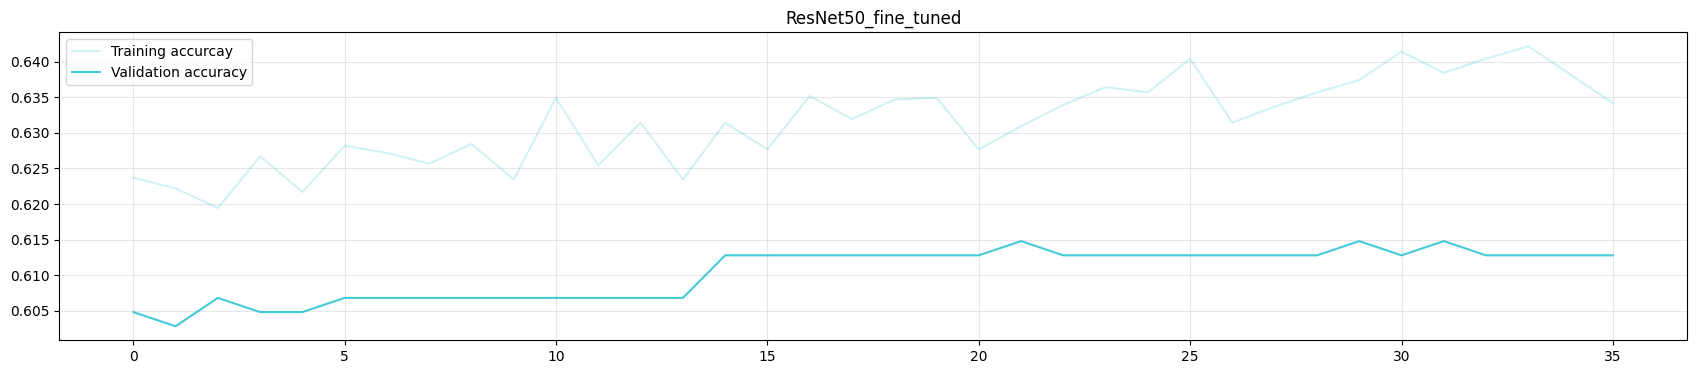

16/16 [==============================] - 1s 36ms/step - loss: 1.0652 - accuracy: 0.6008
ResNet50 process finished here
****************************************************************************************************
31790344/31790344 [==============================] - 0s 0us/step
Model: "efficientnetb2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 96, 96, 3)            0         ['input_7[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 96, 96, 3)            7         ['rescaling[0][0]']          

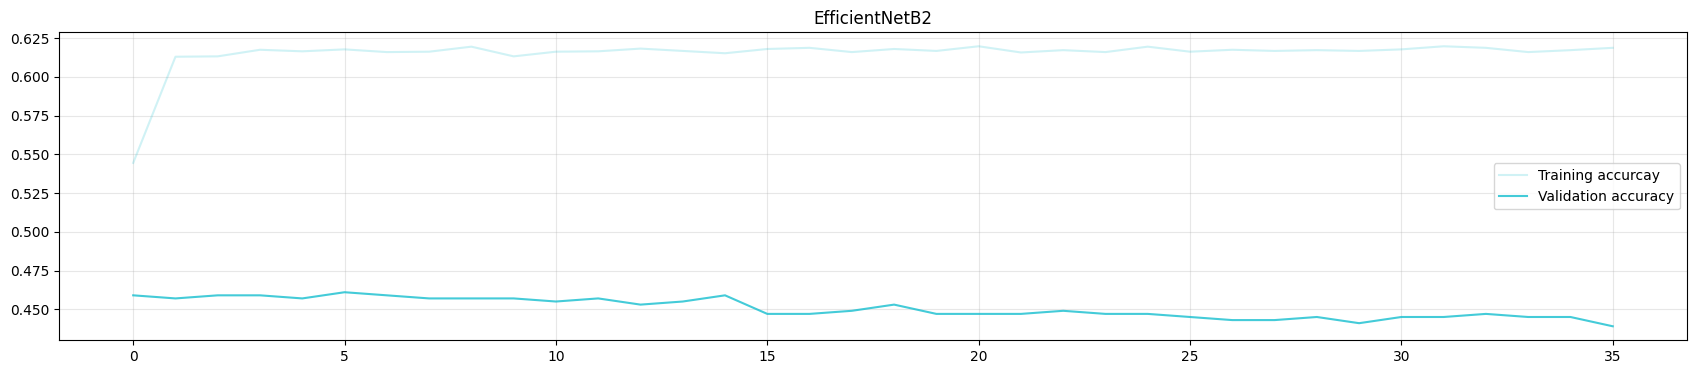

16/16 [==============================] - 2s 70ms/step - loss: 0.7442 - accuracy: 0.4631
****************************************************************************************************
Fine_tuning is doing
Epoch 1/150
63/63 [==============================] - ETA: 0s - loss: 0.6709 - accuracy: 0.6174
Epoch 1: val_accuracy did not improve from 0.46108
63/63 [==============================] - 42s 249ms/step - loss: 0.6709 - accuracy: 0.6174 - val_loss: 0.7446 - val_accuracy: 0.4571
Epoch 2/150
63/63 [==============================] - ETA: 0s - loss: 0.6725 - accuracy: 0.6139
Epoch 2: val_accuracy did not improve from 0.46108
63/63 [==============================] - 10s 162ms/step - loss: 0.6725 - accuracy: 0.6139 - val_loss: 0.7450 - val_accuracy: 0.4571
Epoch 3/150
63/63 [==============================] - ETA: 0s - loss: 0.6695 - accuracy: 0.6172
Epoch 3: val_accuracy did not improve from 0.46108
63/63 [==============================] - 10s 161ms/step - loss: 0.6695 - accuracy: 0.617

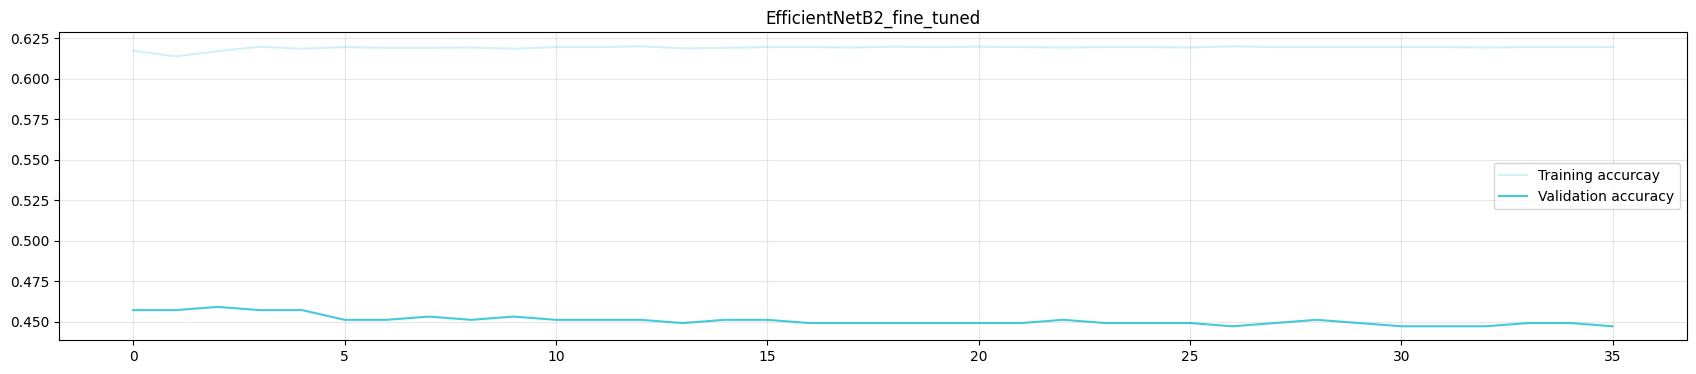

16/16 [==============================] - 1s 33ms/step - loss: 0.7443 - accuracy: 0.4591
EfficientNetB2 process finished here
****************************************************************************************************
214201816/214201816 [==============================] - 1s 0us/step
Model: "efficientnetv2-m"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 rescaling_2 (Rescaling)     (None, 96, 96, 3)            0         ['input_9[0][0]']             
                                                                                                  
 stem_conv (Conv2D)          (None, 48, 48, 24)           648       ['rescaling_2[0][0]

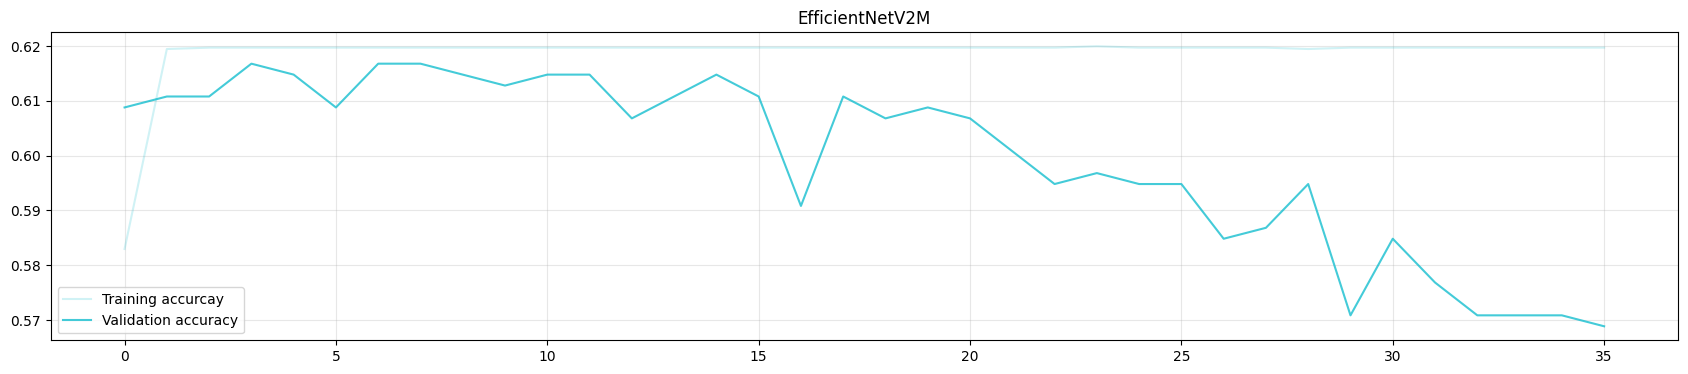

16/16 [==============================] - 3s 124ms/step - loss: 0.6774 - accuracy: 0.5848
****************************************************************************************************
Fine_tuning is doing
Epoch 1/150
63/63 [==============================] - ETA: 0s - loss: 0.6641 - accuracy: 0.6197
Epoch 1: val_accuracy did not improve from 0.61677
63/63 [==============================] - 111s 529ms/step - loss: 0.6641 - accuracy: 0.6197 - val_loss: 0.6656 - val_accuracy: 0.6088
Epoch 2/150
63/63 [==============================] - ETA: 0s - loss: 0.6618 - accuracy: 0.6194
Epoch 2: val_accuracy did not improve from 0.61677
63/63 [==============================] - 26s 417ms/step - loss: 0.6618 - accuracy: 0.6194 - val_loss: 0.6656 - val_accuracy: 0.6068
Epoch 3/150
63/63 [==============================] - ETA: 0s - loss: 0.6539 - accuracy: 0.6207
Epoch 3: val_accuracy did not improve from 0.61677
63/63 [==============================] - 26s 415ms/step - loss: 0.6539 - accuracy: 0.6

In [ ]:
for model in model_names:
  dictionary, dictionary_fine, test_accuracy, test_accuracy_fine = define_model(model_name = model, input_shape=input_shape, fine_tune_at=143, base_learning_rate=0.0001)
  del model

## **ImageGenreator**

In [ ]:
# Create the ImageDataGenerator for training data
train_datagen = ImageDataGenerator(
    rotation_range=30,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect',
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input #################### Be careful about Feature Scaling of your model.#####################################################
)

# Generate the training data
train_generator = train_datagen.flow(x_train, y_train, batch_size=32)

In [ ]:
 Create the ImageDataGenerator for validation data
val_datagen = ImageDataGenerator(
preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input#################### Be careful about Feature Scaling of your model.#####################################################
    # Add other preprocessing configurations as needed
)
val_generator = val_datagen.flow(x_val, y_val, batch_size=32)

## **Model**

In [ ]:
def our_model():
  input_shape = (96, 96, 3)
  model = tfk.applications.MobileNetV2(
      input_shape=input_shape,
      include_top=False,
      weights="imagenet",
      pooling='avg',
  )
  # Use the supernet as feature extractor, i.e. freeze all its weigths

  model.trainable = False

  # Create an input layer based on your input shape
  input_layer = tfkl.Input(shape=input_shape)

  # Connect MobileNetV2 to the input layer
  x = model(input_layer)
  x = tfkl.Flatten()(x)
  x = tfkl.Dropout(0.1)(x)
  x = tfkl.Dense(512, activation='ELU', kernel_initializer = tf.keras.initializers.HeUniform(seed))(x)
  x = tfkl.Dropout(0.5)(x)
  x = tfkl.Dense(128,activation=None, kernel_initializer = tf.keras.initializers.HeUniform(seed))(x)
  #

  # Be Aware I used softamx.############################################################################################
  outputs = tfkl.Dense(2, activation='softmax' , kernel_initializer=keras.initializers.GlorotUniform(seed) )(x)

  # Create a Model connecting input and output
  model = tf.keras.Model(inputs=input_layer, outputs=outputs, name='model')

  return model

In [ ]:
name_of_your_model = "MobileNetV2"
My_callbacks = [earlystopping(), Checkpoint(f"/content/{name_of_your_model}"), learning_rate_reduction()]
MobileNetV2 = our_model()

In [ ]:
MobileNetV2.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

In [ ]:
history =MobileNetV2.fit(train_generator, epochs=epochs, validation_data=val_generator, callbacks=My_callbacks,class_weight = class_weights_dict )

## **Graph**

In [ ]:
plot_accuracy(history=history.history,title=f'{name_of_your_model}_accuracy')